# Continuous Control

---

This repository is based on the continuous control problem studied in the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program and demonstrates a variant of the PPO learning algorithm in an environment with a continuous action space.

![Actor](resources/small_agent.gif)

## 1. General description

In this environment, a double-jointed arm can move to target locations. A reward of +0.04 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

The environment is implemented as a Unity environment available in two versions:
- A version that contains a single agent.
- A version that contains 20 identical agents, each with its own copy of the environment.

The task is episodic, and in order to solve the environment, the average of the total score of an epsidoe over all agents over 100 consecutive episodes must be above +30.

## 2. Algorithm

The algorithm used is a variant of Proximal Policy Optimization (PPO) with a Generalized Advantage Estimation (GAE) and a clipped objective function. The algorithm uses a finite horizon instead of reward discounting. In the following we give a very brief summary of the elements, a more detailed overview can be found in the referenced sources or e.g. in this two lecture from the [Deep RL Bootcamp](https://sites.google.com/view/deep-rl-bootcamp/lectures): [Policy gradients and GAE](https://www.youtube.com/watch?v=S_gwYj1Q-44), [PPO](https://www.youtube.com/watch?v=xvRrgxcpaHY).

### 2.1 Proximal Policy Optimization (PPO)

Proximal Policy Optimization is a variant of policy gradient methods that is used to improve sample efficiency. Policy gradient methods are based on the objective to maximize the expectation $\mathbb{E}_{\tau \sim \pi_\theta}\left[R(\tau)\right]$ of the total reward $R(\tau)$ for trajectories $\tau=(s_0, a_0, r_0, s_1, a_1, r_1, \dots)$ under a parameterized policy $\pi_\theta(\tau)$.

The gradient of the above objective can be derived as 

$$
g
= \nabla_\theta \, \mathbb{E}_{\tau \sim \pi_\theta} \!\! \left[ \sum_{t=0}^H \log{\pi_\theta(a_t|s_t)} (R_t^f - b(s_t) \right]
= \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^H \frac{\nabla_\theta \pi_\theta(a_t|s_t)}{\pi_\theta(a_t|s_t)} (R_t^f - b(s_t) \right]
$$

where $R_f^t$ denotes the future reward at time step $t$ and $b(s_t)$ is a baseline which can depend on the state $s_t$. An equivalent formulation can be obtained by looking at the expectation with respect to a different policy $\pi_{\theta'}$:

$$
g
= \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^H \frac{\nabla_\theta \pi_\theta(a_t|s_t)}{\pi_\theta(a_t|s_t)} (R_t^f - b(s_t) \right]
= \mathbb{E}_{\tau \sim \pi_{\theta'}}  \left[ \sum_{t=0}^H \frac{\left. \nabla_\theta \pi_\theta(a_t|s_t) \right|_{\theta = \theta'}}{\pi_{\theta'}(a_t|s_t)} (R_t^f - b(s_t) \right].
$$

When the above expectations are approximated by data from sampled trajectories, this implies that we can estimate the gradient for an evolved policy $\pi_\theta$ from trajectories that were sampled using the old policy $\pi_{\theta'}$ reasonably well if $\theta$ is in a proximity of $\theta'$. In other words, we can reuse trajectories generated with $\pi_{\theta'}$ to further optimize $\pi_{\theta}$, as long as $\pi_{\theta}$ does not get too far from $\pi_{\theta'}$.
The above gradient can be obtained by diffentiating the objective function 

$$
L(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta'}}  \left[ \sum_{t=0}^H \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta'}(a_t|s_t)} (R_t^f - b(s_t) \right].
$$

As proposed in this [article](https://arxiv.org/abs/1707.06347), an easy and efficient way protect against the inacurracy introduced by a too large deviation of $\theta$ from $\theta'$ is to clip the ratio $r(\theta) = \frac{\pi_{\theta}}{\pi_{\theta'}}$ to a maximum value of $1 + \epsilon$

$$
L^{PPO}(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta'}} \left [
    \min(r(\theta)(R_t^f - b(s_t)), \rm{clip}(r(\theta), 1-\epsilon, 1+\epsilon) (R_t^f - b(s_t)))
\right],
$$

where the clipping parameter $\epsilon$ is a hyper parameter of the algorithm.


### 2.2 Generalized Advantage Estimation (GAE) Critic

As a baseline $b(s_t)$ we use the state-value function $V_{\pi_\theta}(s_t)$, and replace the term $(R_t^f - V_{\pi_\theta}(s_t))$ with a function approximator $\tilde A(s, a)$ (critic). $\tilde A(s, a)$ is an approximation of the advantage function $A_{\pi_\theta}(s, a) = Q_{\pi_\theta}(s,a) - V_{\pi_\theta}(s)$. To obtain this estimate we use the generalized advantage estimator as described in [this article](https://arxiv.org/abs/1506.02438), which approximates the advantage function using the state-value function as a weighted average over n-step temporal differences $r_t + r_{t+1} + \cdots + r_{t+n-1} + V(s_{t+n}) - V(s_{t})$:

$$
\tilde A^{GAE} = - \tilde V_{\pi_\theta}(s_t) + (1-\lambda)\sum_{k=t}^H \lambda^{(k-t)} \left(\sum_{l=t}^{k-1} r(s_l) + \tilde V(s_k)\right) = \sum_{k=t}^H \lambda^{(k-t)}\left(r_{k} + \tilde V(s_{k+1}) - \tilde V(s_{k})\right) = \sum_{k=t}^H \lambda^{(k-t)}\delta_k^{\tilde V},
$$
where $\delta_t^V = r_t + V(s_{t+1}) - V(s_{t})$.

The estimate $\tilde V$ of the state-value is obtained by minimizing the error between the estimated and sampled state-values for a paramterized estimator $\tilde V_\phi(s_{t})$:
$$
L^V = \hat{\mathbb{E}} \left[ \| R_t^f - \tilde V_\phi(s_{t}) \| \right]
$$

### 2.3 Finite horizon and noise reduction

Instead of discounting of rewards we decided to consider a fixed size finite horizon for the agent. This is implemented by generating full episodes, splitting them with a rolling window corresponding to the horizon of the agent and removing windows in which the agent does not obtain any reward. 

![windows](resources/windows.png)

The reason for this is the following: Though the task is setup to be episodic, it is continuous in it's nature, and actions should have a comparable short term effect. From this observation it seems reasonable to assume that a finite horizon should be sufficient for the agent to solve the task. Further, looking at the actor at the beginning of the learning process, it is evident that it suffers from find a good starting point, as the probability to reach the target by accident is low. Implemening a fixed horizon instead of discounting gives us an easy way to remove windows in which the agent doesn't retrieve any reward. Considering that we can understand the learning process as a directed search driven by the obtained reward, it seems reasonable to assume that these windows do not contribute in a positive way to the learning process.

### 2.3 Approximators and training

For both the approximator $\pi_\theta$ as well as the state-value function $V_\phi$ we use fully connected neural networds with two hidden layers of size 128 and 64 with relu activations. The two networks differ only in the output layers, as described in the following. The approximators are trained in batches and a replay buffer is used, i.e. the  order of timestpes is randomized during training.

#### 2.3.1 Policy approximator

The policy approximator maps a state to a normal distribution  with a fixed variance and an estimated mean for each of the available actions.  The normal distributions are truncated to the interval $[-1,1]$ to conform to the allowed values for the actions. The mean estimate is provided by a neural network as described above, where the size of the output layer corresponds to the number of available actions and uses a $\tanh$ activation function to confine the output to the interval $[-1,1]$.

![Actor net](resources/actor_net.png)

#### 2.3.2 State-Value approximator

The approximator for the state value function maps a state to a real number and is implemented by a neural network as described above with a single node in the output layer without additional activation.

![Critic net](resources/critic_net.png)

### 2.4 Algorithm:

* Init $\theta'$, $\theta$, $\phi$
* For $N$ epochs:
    * Set $\theta' = \theta$
    * Generate $M$ episodes from each agent with respect to $\pi_{\theta'}$
    * Split the episodes into windows of length $m$ using a rolling window
    * Remove windows where no reward is achived
    * Calculate $\pi_{\theta'}(a_t|s_t)$ and $A^{GAE}(s_t, a_t)$ for all time steps in each window
    * For $k$ epochs:
        * Update $\theta$ to optimize $L^{PPO}$ using sampled a batches of $j$ windows
        * Update $\phi$ to optimize $L^V$ using the same batches as in the previous step
 


### 2.5 Further remarks on the algorithm and chosen hyper parameters

* For simplicity we limited the length of the generated episodes to 1000 steps during training which allows us to ignore terminal states.
* The horizon of the agent is limited to 50 steps and from each episode sliding windows with a offset of 5 steps are extracted. This resulting in potentially $(20 + 24 \cdot 19)\cdot 20 = 9520$ windows of 50 steps per episode from 20 agents, from which windows where no reward is obtained are filtered out.
* No reward discounting is used as we already limit the horizon of the agent. 
* Though clipping of the surrogate objective is essential, the clip window can be keept quite large at 0.75.
* The parameter for the GAE is set to 0.75 to provide a noticable amount of variance reduction. 
* After generating 8 epidsodes from the 20 agents, learning is executed on 8 epochs on the sampled data in batches of size 32 and a learning rate of $10^{-4}$.   
* Gradient clipping turned out to be not necessary to solve the environment.
* The variance for the normal distributions is set to 0.5. This is a rather high value considering the range for the action values is the interval $[-1,1]$, but on the one hand a too low variance will cause new policy estimates to differ very quickly from old ones, and on the other hand the variance seems to cancel out over consecutive timesteps.  

### 2.6 Results and performance
The following plot shows the total scores per generated episode, averaged over the 20 agents in each generatino step.
As learning takes only takes place each 8 episodes, improvement happens gradually at each 8th episode. The agent reaches an average of +30 over 100 consecutive episodes during the learning process after 128 generated episodes (for 20 agents). The target score itself is, however, reached already after 56 episodes.

![Simple DNN](scores.png)


### 2.7 Improvements

The agent already seems to come close to the optimal policy, but points were performance could still improved are the inital phase of the episode, i.e. the time the agent needs to first reach the target, as well as reliability, i.e. preventing that the agent looses the target again.

To reach the first point a possibility could be experiment with (progressively) shorter horizons for the agent, as that could force it to achive reward within fewer timesteps. 

For the second point it would be interesting to investigate if it is possible to reduce the variance of the policy approximator during training. This has to go along with a more aggressive clipping of the objective function and eventually a decay in the learning rate. If this can be successful, however, will also depend on the noise present in the sampled trajectories, as that will unavoidable lead to fluctuations of the policy approximator.

## 4. Implementation

In this section we provide a detailed walk through the implementation. To reproduce the above results, however, run the cocontrol.py script from the command line as described in the README without command line parameters.

First we run some neccessary imports.

In [1]:
%matplotlib inline

import pkg_resources
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions.normal as dist
from torch import optim
import numpy as np

from unityagents import UnityEnvironment
from unityagents.exception import UnityEnvironmentException

from cocontrol.util import plot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PLATFORM_PATHS = ['Reacher.app',
        'Reacher_Windows_x86/Reacher.exe',
        'Reacher_Windows_x86_64/Reacher.exe',
        'Reacher_Linux/Reacher.x86',
        'Reacher_Linux_NoVis/Reacher.x86',
        'Reacher_Linux/Reacher.x86_64',
        'Reacher_Linux_NoVis/Reacher.x86_64']

### 4.1. Start the Environment

The environment the agent operates on is based on a pre-built [Unity ML-Agent](https://github.com/Unity-Technologies/ml-agents) and is provided by the *CoControlEnv* class in the *cocontrol.environment* package.

This class encapsulates the pre-built Unity environment, which must be downloaded to one of the following locations **_before running the code cells below_**:

- **Mac**: `"cocontrol/resources/Reacher.app"`
- **Windows** (x86): `"cocontrol/resources/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"cocontrol/resources/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"cocontrol/resources/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"cocontrol/resources/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"cocontrol/resources/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"cocontrol/resources/Reacher_Linux_NoVis/Reacher.x86_64"`

It is important that the *cocontrol/resources* folder **_only contains the agent for your operating system_**!

If the code cell below returns an error, please revisit the installation instructions in the README and double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
# %load -s CoControlEnv cocontrol/environment
class CoControlEnv:
    """Continuous control environment.

    The environment accepts actions and provides states and rewards in response.
    """

    def __init__(self):
        for path in PLATFORM_PATHS:
            try:
                unity_resource = pkg_resources.resource_filename('cocontrol', 'resources/' + path)
                self._env = UnityEnvironment(file_name=unity_resource)
                print("Environment loaded from " + path)
                break
            except UnityEnvironmentException as e:
                print("Attempted to load " + path + ":")
                print(e)
                print("")
                pass

        if not hasattr(self, '_env'):
            raise Exception("No unity environment found, setup the environment as described in the README.")

        # get the default brain
        self._brain_name = self._env.brain_names[0]
        self._brain = self._env.brains[self._brain_name]

        self._info = None
        self._scores = None
        self._score_history = ()

    def generate_episode(self, agent, max_steps=None, train_mode=False):
        """Create a generator for and episode driven by an actor.
        Args:
            actor: An actor that provides the next action for a given state.
            max_steps: Maximum number of steps (int) to take in the episode. If
                None, the episode is generated until a terminal state is reached.

        Returns:
            A generator providing a tuple of the current state, the action taken,
            the obtained reward, the next state and a flag whether the next
            state is terminal or not.
        """
        states = self.reset(train_mode=train_mode)
        is_terminal = False
        count = 0

        while not is_terminal and (max_steps is None or count < max_steps):
            actions = agent.act(states)
            rewards, next_states, is_terminals = self.step(actions)

            step_data = (states, actions, rewards, next_states, is_terminals)

            states = next_states
            is_terminal = np.any(is_terminals)
            count += 1
            if np.any(np.isnan(states)):
                raise ValueError("Nan from env")
            # print("step" + str(count))

            yield step_data

        self._score_history += (self.get_score(), )
        self._scores = None

    def reset(self, train_mode=False):
        """Reset and initiate a new episode in the environment.

        Args:
            train_mode: Indicate if the environment should be initiated in
                training mode or not.

        Returns:
            The initial state of the episode (np.array).
        """
        # if self._info is not None and not np.any(self._info.local_done):
        #     raise Exception("Env is active, call terminate first")

        if self._scores is not None:
            self._score_history += (np.mean(self._scores))

        self._info = self._env.reset(train_mode=train_mode)[self._brain_name]
        self._scores = np.zeros(self.get_agent_size())

        return self._info.vector_observations

    def step(self, actions):
        """Execute an action on all instances.

        Args:
            action: An tensor of ints representing the actions each instance.

        Returns:
            A tuple containing the rewards (floats), the next states (np.array) and
            a booleans indicating if the next state is terminal or not.
        """
        if self._info is None:
            raise Exception("Env is not active, call reset first")

        if torch.is_tensor(actions):
            actions = actions.numpy()

        self._info = self._env.step(actions)[self._brain_name]
        next_states = self._info.vector_observations
        rewards = self._info.rewards
        is_terminals = self._info.local_done
        self._scores += np.array(rewards)

        return rewards, next_states, is_terminals

    def terminate(self):
        self._info = None
        if self._scores is not None:
            self._score_history += (self.get_score(), )
        self._scores = None

    def close(self):
        self.terminate()
        self._env.close()

    def get_score(self):
        """Return the cumulative average reward of the current episode."""
        return np.mean(self._scores) if self._scores is not None else self._score_history[-1]

    def get_score_history(self):
        """Return the cumulative average reward of all episodes."""
        return self._score_history

    def clear_score_history(self):
        """Clear the cumulative average reward of all episodes."""
        self._scores = None
        self._score_history = ()

    def get_agent_size(self):
        if self._info is None:
            raise ValueError("No agents are initialized")

        return len(self._info.agents)

    def get_action_size(self):
        return self._brain.vector_action_space_size

    def get_state_size(self):
        return self._brain.vector_observation_space_size


To generate episodes on the environment the *CoControlAgent* class provides an agent that selects actions in a particular state of the environement based on a policy function:


In [3]:
# %load -s CoControlAgent cocontrol/environment
class CoControlAgent:
    """Agent based on a policy approximator."""

    def __init__(self, policy):
        """Initialize the agent.

        Args:
            pi: policy-function that is callable with n states and returns a
                (n, a)-dim array-like containing the value of each action.
        """
        self._policy = policy

    def act(self, states):
        """Select actions for the given states.

        Args:
            state: An array-like of states to choose the actions for.
        Returns:
            An array-like of floats representing the actions.
        """
        if not torch.is_tensor(states):
            try:
                states = torch.from_numpy(states, dtype=torch.float)
            except:
                states = torch.from_numpy(np.array(states, dtype=np.float))
        else:
            states = states.float()

        with torch.no_grad():
            return self._policy.sample(states)

    def get_policy(self):
        return self._policy


Now we can setup and test the environment and run an episode with a random or dummy policy. To run the test, uncomment the *test_env()* invocation and choose the policy you like.

**_After you ran the test you need to comment it out again and restart the kernel, as recreating the environment does not work!_**

In [4]:
env = CoControlEnv()

def test_env():
    # all actions are between -1 and 1
    class DummyPolicy:
        def sample(self, state):
            return torch.rand(env.get_agent_size(), env.get_action_size()) * 2.0 - 1.0

    agent = CoControlAgent(DummyPolicy())
    episode = enumerate(env.generate_episode(agent, max_steps = 1000))
    for count, step_data in episode:
        # Consume the generated steps
        pass

    env.close()

    
##### UNCOMMENT THIS TO TEST, COMMENT OUT AND RESTART THE KERNEL AFTERWARDS ####

# test_env()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environment loaded from Reacher.app


### 4.2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
states = env.reset()

# number of agents
num_agents = env.get_agent_size()
print('Number of agents:', num_agents)

# size of each action
action_size = env.get_action_size()
print('Size of each action:', action_size)

# examine the state space 
state_size = env.get_state_size()
print('Size of each states:', state_size)

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], states.shape[1]))
print('The state for the first agent looks like:', states[0])

env.clear_score_history()

Number of agents: 20
Size of each action: 4
Size of each states: 33
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4.3 Models and policy

The models to appoximate the action means of the policy distributions (*Actor*) and the state-value function (*Critic*) are implemented as PyTorch *nn.Module*. As they share the same hidden layers, they extend a common base class, and only add their individual output layers.

In [6]:
# %load -s PPOModel cocontrol/model
class PPOModel(nn.Module):
    """Base module for Actor and Critic models."""

    def __init__(self, state_size, output_size, seed, fc1_units, fc2_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            output (int): Dimension of the output
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(PPOModel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_size)
        self._reset_parameters()

    def _reset_parameters(self):
        self.fc1.weight.data.uniform_(*self._init_limits(self.fc1))
        self.fc2.weight.data.uniform_(*self._init_limits(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def _init_limits(self, layer):
        input_size = layer.weight.data.size()[0]
        lim = 1. / np.sqrt(input_size)

        return (-lim, lim)


In [7]:
# %load -s Actor cocontrol/model
class Actor(PPOModel):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=2, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__(state_size, action_size, seed, fc1_units, fc2_units)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> action means."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        return F.tanh(self.fc3(x))


In [8]:
# %load -s Critic cocontrol/model
class Critic(PPOModel):
    """Critic (Value) Model."""

    def __init__(self, state_size, seed=2, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Critic, self).__init__(state_size, 1, seed, fc1_units, fc2_units)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an critic (value function) network that maps states -> values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        return self.fc3(x)


The policy itself is implemented in a separate class that wraps the mean approximator and  provides normal distributions for each action. The *Policy* class can be used to calculate the log probabilities of given state-action pairs as well a to sample actions in a given state.

In [9]:
# %load -s Policy cocontrol/model
class Policy():
    """Policy that provides action probabilities and samples actions accordingly."""

    def __init__(self, model, sigma=1.0, cap=[-1.0, 1.0]):
        """Initialize parameters.
        Params
        ======
            model fn: state -> means: A model that maps states to means of the
                  action distributions
            sigma (float): variance of the action distributions
            cap (list): limits for the action values
        """
        if sigma <= 0.0:
            raise ValueError("sigma must be positive: " + str(sigma))

        self._model = model
        self._sigma = sigma
        self._cap_min = cap[0] if cap is not None else None
        self._cap_max = cap[1] if cap is not None else None

    def log_prob(self, states, actions):
        """Log-probabilities of the given actions for the given states.

        Params
        ======
        states (tensor): dimensions (agents, steps, state_size)
        actions (tensor): dimensions (agents, steps, action_size)

        Returns
        ======
        log probabilities (tensor): dimensions (agents, steps, 1)
        """
        if not states.dim() == actions.dim() == 3:
            raise ValueError("dimensions are too small, unsqueeze: " + str(states.size()) + "-" + str(actions.size()))

        if not states.size()[:2] == actions.size()[:2]:
            raise ValueError("dimenions don't match: " + str(states.size()) + "-" + str(actions.size()))

        states = states.to(device, dtype=torch.float)
        actions = actions.to(device, dtype=torch.float)

        distributions = self.distributions(states)

        log_probs = distributions.log_prob(actions).float()
        if self._cap_max is not None:
            boundary = torch.ge(actions, self._cap_max)
            if boundary.any():
                log_cdf = torch.log(1 - distributions.cdf(actions)).float()
                log_probs = torch.where(boundary, log_cdf, log_probs)
        if self._cap_min is not None:
            boundary = torch.le(actions, self._cap_min)
            if boundary.any():
                log_cdf = torch.log(distributions.cdf(actions)).float()
                log_probs = torch.where(boundary, log_cdf, log_probs)

        return torch.sum(log_probs, dim=2).unsqueeze(2)

    def distributions(self, states):
        means = self._model(states.to(device, dtype=torch.float))

        return dist.Normal(means, self._sigma)

    def sample(self, states):
        """Sample actions for the given states according to the policy.

        Params
        ======
        states (tensor): dimensions (agents, steps, state_size)

        Returns
        ======
        actions (tensor): dimensions (agents, steps, action_size)
        """
        sample = self.distributions(states).sample()

        if self._cap_min is None or self._cap_max is None:
            return sample
        else:
            return torch.clamp(sample, self._cap_min, self._cap_max)


### 4.4 PPO implementation

The implementation of the algorithm is contained in the *PPOLearner* class that executes the the PPO algorithm with the given paramters

In [10]:
# %load -s PPOLearner cocontrol/training
class PPOLearner():
    """Implementation of the PPO algorithm.
    """

    def __init__(self, env=None,
            episodes_in_epoch=8, ppo_epochs=8, batch_size=32,
            window_size=50, window_step=2,
            ppo_clip=0.75, sigma=0.5,
            gamma=1.0, gae_tau=0.75, lr=1e-4):
        # Don't instantiate as default as the constructor already starts the unity environment
        self._env = env if env is not None else CoControlEnv()

        self._state_size = self._env.get_state_size()
        self._actions = self._env.get_action_size()

        self._episodes_in_epoch = episodes_in_epoch
        self._ppo_epochs = ppo_epochs
        self._batch_size = batch_size

        self._window_size = window_size
        self._window_step = window_step

        self._sigma = sigma
        self._gamma = gamma
        self._gae_tau = gae_tau

        self._ppo_clip = ppo_clip
        self._lr = lr

        self._policy_model = Actor(self._state_size, self._actions).to(device)
        self._value_model = Critic(self._state_size).to(device)

        self._policy_optimizer = optim.Adam(self._policy_model.parameters(), lr, eps=1e-5)
        self._value_optimizer = optim.Adam(self._value_model.parameters(), lr, eps=1e-5)

        self._policy_model.eval()
        self._value_model.eval()

        print("Initialize PPOLearner with model:")
        print(self._policy_model)
        print(self._value_model)

    def save(self, path):
        """Store the learning result.

        Store the parameters of the current models to the given path.
        """
        torch.save(self._policy_model.state_dict(), "actor_" + path)
        torch.save(self._value_model.state_dict(), "critic_" + path)

    def load(self, path):
        """Load learning results.

        Load the parameters from the given path into the models.
        """
        self._policy_model.load_state_dict(torch.load("actor_" + path))
        self._value_model.load_state_dict(torch.load("critic_" + path))
        self._policy_model.to(device)

    def get_agent(self, sigma):
        """Return an agent based on the current policy model with the given variance.
        """
        return CoControlAgent(self.get_policy(sigma))

    def get_policy(self, sigma):
        """Return a policy based on the model of the learner.
        """
        return Policy(self._policy_model, sigma)

    def train(self, num_epochs=100):
        for epoch in range(num_epochs):
            policy = self.get_policy(self._sigma)

            episodes = ( self._generate_episode(policy, epoch) for i in range(self._episodes_in_epoch) )
            episodes = ( e for e in zip(*episodes) )

            states, actions, rewards, next_states, is_terminals = \
                    [ torch.cat(component, dim=0).detach() for component in episodes ]

            returns = self._calculate_returns(rewards).detach()
            log_probs = policy.log_prob(states, actions).detach()
            values = self._value_model(states).detach()
            next_values = self._value_model(next_states).detach()

            td_errors = rewards + self._gamma * next_values - values
            advantages = self._calculate_advantages(td_errors)

            advantages = (advantages - advantages.mean()) / advantages.std()

            print("Collected windows: " + str(states.size()))

            # Validate dimensions
            for data in (states, actions, next_states, rewards, is_terminals,
                    returns, advantages, values, log_probs):
                assert len(set([ d.size()[0] for d in data ])) == 1
            for data in (states, actions, next_states, rewards, is_terminals,
                    returns, advantages, values, log_probs):
                assert len(set([ d.size()[1] for d in data ])) == 1
            assert self._env.get_state_size() == states.size()[2] == next_states.size()[2]
            assert self._env.get_action_size() == actions.size()[2]
            for data in (rewards, is_terminals, returns, advantages, values, log_probs):
                assert 1 == data.size()[2]

            self._value_model.train()
            self._policy_model.train()

            for ppo_epoch in range(self._ppo_epochs):
                sampler = [idx for idx in self._random_sample(np.arange(states.size(0)), self._batch_size) ]
                for batch_indices in sampler:
                    batch_indices = torch.tensor(batch_indices).long()
                    sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages = [
                            data[batch_indices]
                            for data in [states, actions, log_probs, returns, advantages] ]

                    new_log_probs = policy.log_prob(sampled_states.detach(), sampled_actions.detach())
                    ratio = (new_log_probs - sampled_log_probs_old.detach()).exp()

                    obj = ratio * sampled_advantages.detach()
                    obj_clipped = ratio.clamp(1.0 - self._ppo_clip, 1.0 + self._ppo_clip) \
                            * sampled_advantages.detach()
                    policy_loss = - torch.min(obj, obj_clipped).mean()

                    new_value = self._value_model(sampled_states.detach())
                    value_loss = 0.5 * (sampled_returns.detach() - new_value).pow(2).mean()

                    self._value_optimizer.zero_grad()
                    value_loss.backward()
                    self._value_optimizer.step()

                    self._policy_optimizer.zero_grad()
                    policy_loss.backward()
                    self._policy_optimizer.step()

                self._value_model.eval()
                self._policy_model.eval()

                yield policy_loss, self._env.get_score(), ppo_epoch == self._ppo_epochs - 1

    def _generate_episode(self, policy, epoch):
        agent = CoControlAgent(policy)

        episode = ( step_data for step_data in self._env.generate_episode(agent, max_steps=1000, train_mode=True) )
        episode = ( episode_data for episode_data in zip(*episode) )

        # state = tuple of (1,33) arrays, etc.., concat along first dimension
        states, actions, rewards, next_states, is_terminals = [
                torch.stack(tuple(self._to_tensor(step)[0] for step in data), dim=1)
                for data in episode ]

        assert self._env.get_agent_size() == states.size()[0]

        #split episodes
        states, actions, rewards, next_states, is_terminals = [
                self._split(data, self._window_size)
                for data in [states, actions, rewards, next_states, is_terminals] ]

        positive_rewards = torch.sum(rewards, dim=1).squeeze() > 0.0
        states, actions, rewards, next_states, is_terminals = [
                data[positive_rewards,:,:]
                for data in [states, actions, rewards, next_states, is_terminals] ]

        # Verify dimensions
        assert states.size()[0] == actions.size()[0] == rewards.size()[0] \
                == next_states.size()[0] == is_terminals.size()[0]
        assert self._env.get_state_size() == states.size()[2] == next_states.size()[2]
        assert self._env.get_action_size() == actions.size()[2]
        assert 1 == rewards.size()[2] == is_terminals.size()[2]

        print("Generated episode: " + str(states.size()[0]) + "/" + str(len(positive_rewards)) \
                + " windows (" + str(states.size()[1]) + ")")

        return (states, actions, rewards, next_states, is_terminals) if states.nelement() > 0 \
                else self._generate_episode(policy)

    def _cat_component(self, episodes, component):
        return torch.cat(episodes[component], dim=0)

    def _split(self, x, split_size):
        if x.size()[1] % split_size != 0:
            raise ValueError("Illegal state, episode cannot be split: " + str(x.size()))

        splits = x.size()[1] // split_size
        step = self._window_step

        windows = x.view(splits*x.size()[0], split_size, x.size()[2])
        shifted_windows = tuple([ x[:,i:-split_size+i,:].contiguous()
                .view((splits-1)*x.size()[0], split_size, x.size()[2])
                for i in range(step, split_size, step) ])

        return torch.cat((windows,) + shifted_windows, dim=0)

    def _to_tensor(self, *arrays, dtype=torch.float):
        results = [ torch.tensor(a).to(device, dtype=dtype) if not torch.is_tensor(a) else a
                for a in arrays ]

        return tuple(result.unsqueeze(dim=1) if result.dim() == 1 else result
                for result in results)

    def _random_sample(self, indices, batch_size):
        indices = np.asarray(np.random.permutation(indices))
        batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
        for batch in batches:
            yield batch
        r = len(indices) % batch_size
        if r:
            yield indices[-r:]

    def _calculate_returns(self, rewards):
        flipped = torch.flip(rewards, dims=(1,))
        result = torch.zeros_like(flipped)
        result[:,0,:] = flipped[:, 0, :]
        for i in range(1, flipped.size()[1]):
            result[:,i,:] = self._gamma * result[:,i-1,:] + flipped[:,i,:]

        return torch.flip(result, dims=(1,))

    def _calculate_advantages(self, td_errors):
        flipped = torch.flip(td_errors, dims=(1,))
        result = torch.zeros_like(flipped)
        result[:,0,:] = flipped[:, 0, :]
        for i in range(1, flipped.size()[1]):
            result[:,i,:] = self._gamma * self._gae_tau * result[:,i-1,:] + flipped[:,i,:]

        return torch.flip(result, dims=(1,))


### 4.5 Training
Now we can train the agent. For demonstration purposes we train the agent only for 10 epochs, and use a window step size of 5 to speed up training. This is, however, enough to get close to the optimal policy:

Initialize PPOLearner with model:
Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


/Users/tkb/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generated episode: 248/3820 windows (50)
Generated episode: 130/3820 windows (50)
Generated episode: 263/3820 windows (50)
Generated episode: 158/3820 windows (50)
Generated episode: 269/3820 windows (50)
Generated episode: 199/3820 windows (50)
Generated episode: 203/3820 windows (50)
Generated episode: 177/3820 windows (50)
Collected windows: torch.Size([1647, 50, 33])

Epoch: 1 - score history (all epochs): avg:+0.249 (min:+0.2/current:+0.2/max:+0.4)

Generated episode: 92/3820 windows (50)
Generated episode: 88/3820 windows (50)
Generated episode: 106/3820 windows (50)
Generated episode: 59/3820 windows (50)
Generated episode: 55/3820 windows (50)
Generated episode: 89/3820 windows (50)
Generated episode: 68/3820 windows (50)
Generated episode: 153/3820 windows (50)
Collected windows: torch.Size([710, 50, 33])

Epoch: 2 - score history (all epochs): avg:+0.180 (min:+0.1/current:+0.1/max:+0.4)

Generated episode: 807/3820 windows (50)
Generated episode: 771/3820 windows (50)
Generat

/Users/tkb/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tkb/anaconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


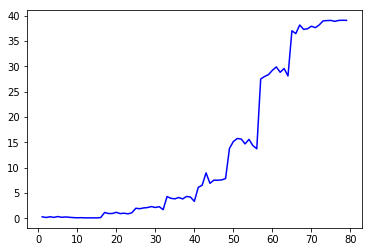

In [11]:
episode_cnt = 0
for cnt, data in enumerate(PPOLearner(env=env, window_step=5).train(10)):
    performance, score, terminal = data

    if terminal:
        episode_cnt += 1
        print("\nEpoch: {} - score history (all epochs): avg:{:+.3f} (min:{:+.1f}/current:{:+.1f}/max:{:+.1f})\n".format(
                episode_cnt, np.mean(env.get_score_history()),
                min(env.get_score_history()), env.get_score(), max(env.get_score_history())))

        
plot(env.get_score_history(), windows=[1], colors=['b'], labels=["Score"], path=None)

### 4.6 Running the trained agent
Finally let's watch the trained agents doing their work! We load the stored parameters files and execute the agent:

In [12]:
learner = PPOLearner(env=env)
learner.load("parameters.pt")
replay_agent = learner.get_agent(0.2)

episode = env.generate_episode(replay_agent)

for count, step_data in enumerate(episode):
    # Consume the generated steps
    pass

print("Score:    " + str(env.get_score()))

Initialize PPOLearner with model:
Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
Score:    39.15849912473932
